In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
762   -0.025464
763   -0.054690
764    0.003660
765    0.079245
766    0.087195
767    0.007241
768   -0.089894
769   -0.133530
770   -0.040963
771    0.118600
772    0.187990
773    0.001373
774   -0.141620
775   -0.250010
776   -0.037291
777    0.165080
778    0.321170
779    0.303980
780    0.023459
781   -0.196880
782   -0.433020
783   -0.465270
784   -0.481880
785   -0.474570
786   -0.336840
787   -0.162550
788    0.054420
789    0.320210
790    0.440940
791    0.622760
Name: f0, Length: 792, d

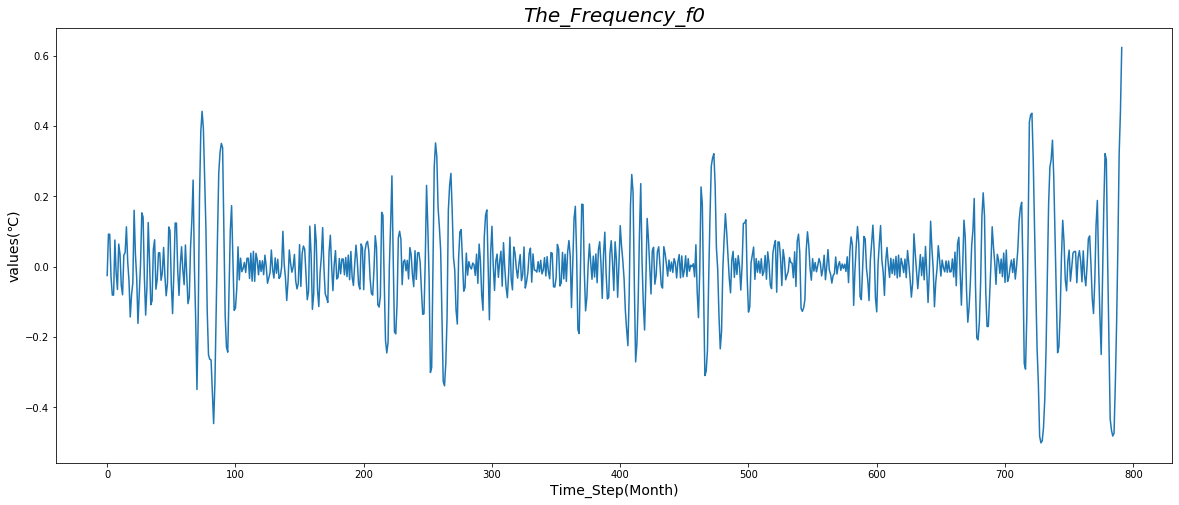

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 5s - loss: 0.0139
Epoch 2/200
 - 2s - loss: 0.0137
Epoch 3/200
 - 2s - loss: 0.0137
Epoch 4/200
 - 2s - loss: 0.0137
Epoch 5/200
 - 2s - loss: 0.0136
Epoch 6/200
 - 2s - loss: 0.0133
Epoch 7/200
 - 2s - loss: 0.0137
Epoch 8/200
 - 2s - loss: 0.0132
Epoch 9/200
 - 2s - loss: 0.0133
Epoch 10/200
 - 2s - loss: 0.0133
Epoch 11/200
 - 2s - loss: 0.0124
Epoch 12/200
 - 2s - loss: 0.0119
Epoch 13/200
 - 7s - loss: 0.0123
Epoch 14/200
 - 6s - loss: 0.0113
Epoch 15/200
 - 5s - loss: 0.0111
Epoch 16/200
 - 4s - loss: 0.0109
Epoch 17/200
 - 3s - loss: 0.0107
Epoch 18/200
 - 3s - loss: 0.0106
Epoch 19/200
 - 3s - loss: 0.0105
Epoch 20/200
 - 3s - loss: 0.0100
Epoch 21/200
 - 3s - loss: 0.0097
Epoch 22/200
 - 3s - loss: 0.0099
Epoch 23/200
 - 3s - loss: 0.0096
Epoch 24/200
 - 3s - loss: 0.0093
Epoch 25/200
 - 3s - loss: 0.0096
Epoch 26/200
 - 6s - loss: 0.0093
Epoch 27/200
 - 2s - loss: 0.0094
Epoch 28/200
 - 2s - loss: 0.0094
Epoch 29/

(63, 12)


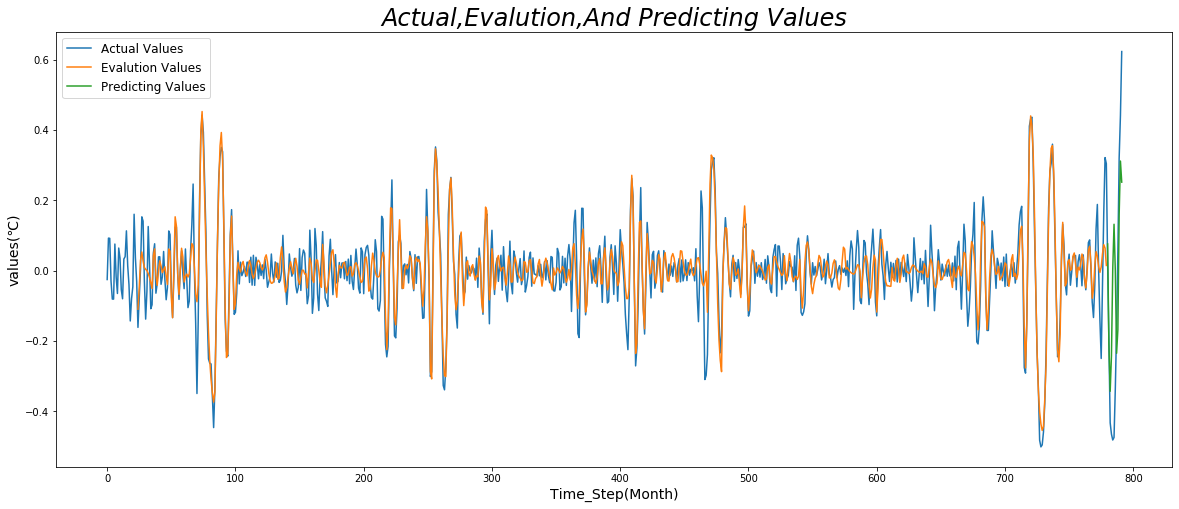

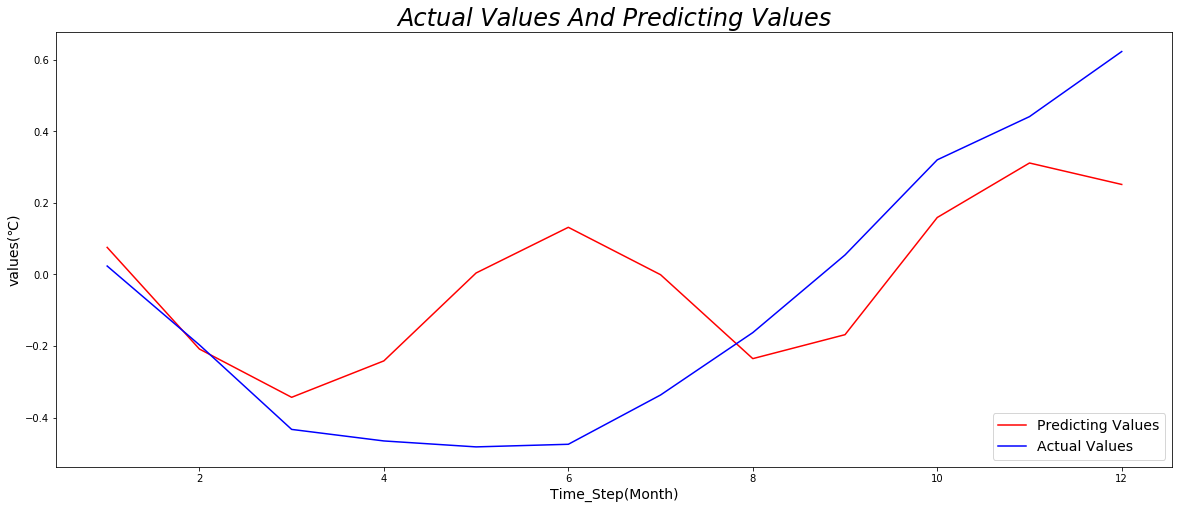

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
762   -0.056685
763   -0.023493
764    0.022220
765    0.044032
766    0.021371
767   -0.025670
768   -0.066672
769   -0.071024
770   -0.019692
771    0.057821
772    0.119830
773    0.133310
774    0.099123
775    0.024204
776   -0.080189
777   -0.182900
778   -0.248040
779   -0.249480
780   -0.197310
781   -0.111500
782   -0.011624
783    0.087047
784    0.177220
785    0.255040
786    0.318450
787    0.365760
788    0.395270
789    0.405300
790    0.392990
791    0.350710
Name: f1, Length: 792, d

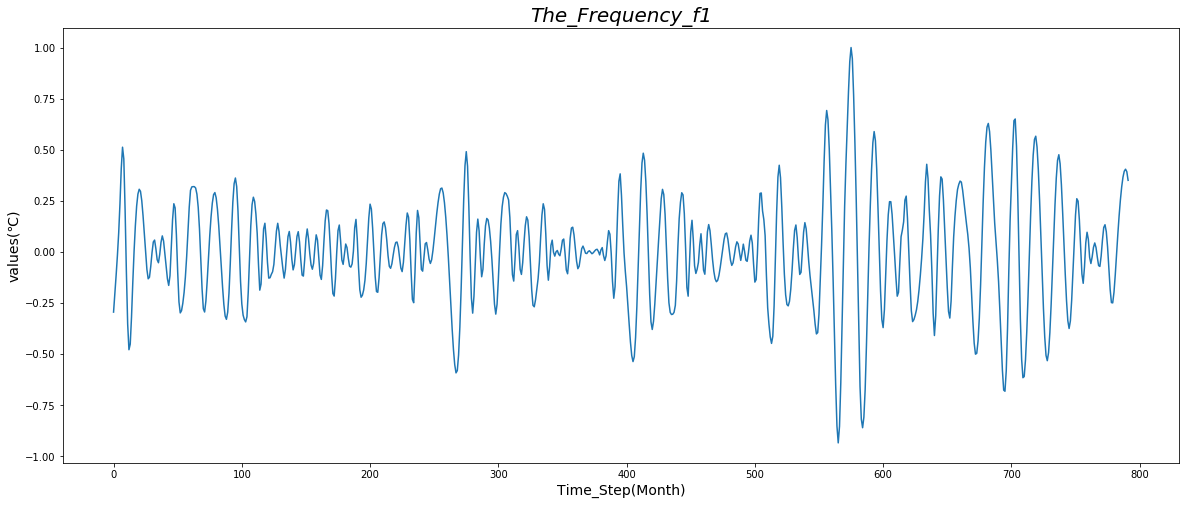

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 7s - loss: 0.0641
Epoch 2/200
 - 3s - loss: 0.0568
Epoch 3/200
 - 2s - loss: 0.0452
Epoch 4/200
 - 3s - loss: 0.0423
Epoch 5/200
 - 2s - loss: 0.0410
Epoch 6/200
 - 2s - loss: 0.0404
Epoch 7/200
 - 2s - loss: 0.0373
Epoch 8/200
 - 2s - loss: 0.0335
Epoch 9/200
 - 2s - loss: 0.0308
Epoch 10/200
 - 2s - loss: 0.0297
Epoch 11/200
 - 2s - loss: 0.0315
Epoch 12/200
 - 2s - loss: 0.0312
Epoch 13/200
 - 2s - loss: 0.0292
Epoch 14/200
 - 2s - loss: 0.0272
Epoch 15/200
 - 2s - loss: 0.0274
Epoch 16/200
 - 2s - loss: 0.0284
Epoch 17/200
 - 2s - loss: 0.0279
Epoch 18/200
 - 2s - loss: 0.0266
Epoch 19/200
 - 2s - loss: 0.0265
Epoch 20/200
 - 2s - loss: 0.0260
Epoch 21/200
 - 2s - loss: 0.0254
Epoch 22/200
 - 2s - loss: 0.0249
Epoch 23/200
 - 2s - loss: 0.0244
Epoch 24/200
 - 2s - loss: 0.0232
Epoch 25/200
 - 2s - loss: 0.0233
Epoch 26/200
 - 2s - loss: 0.0255
Epoch 27/200
 - 2s - loss: 0.0229
Epoch 28/200
 - 2s - loss: 0.0226
Epoch 29/200
 - 2s - loss: 0.0230
Epoch 30/200
 - 2s - lo

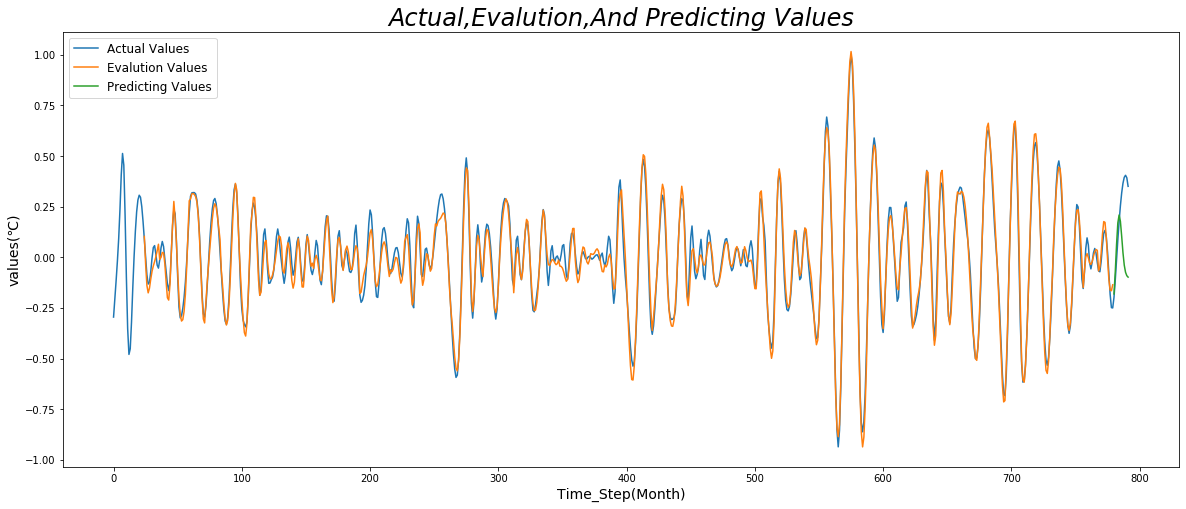

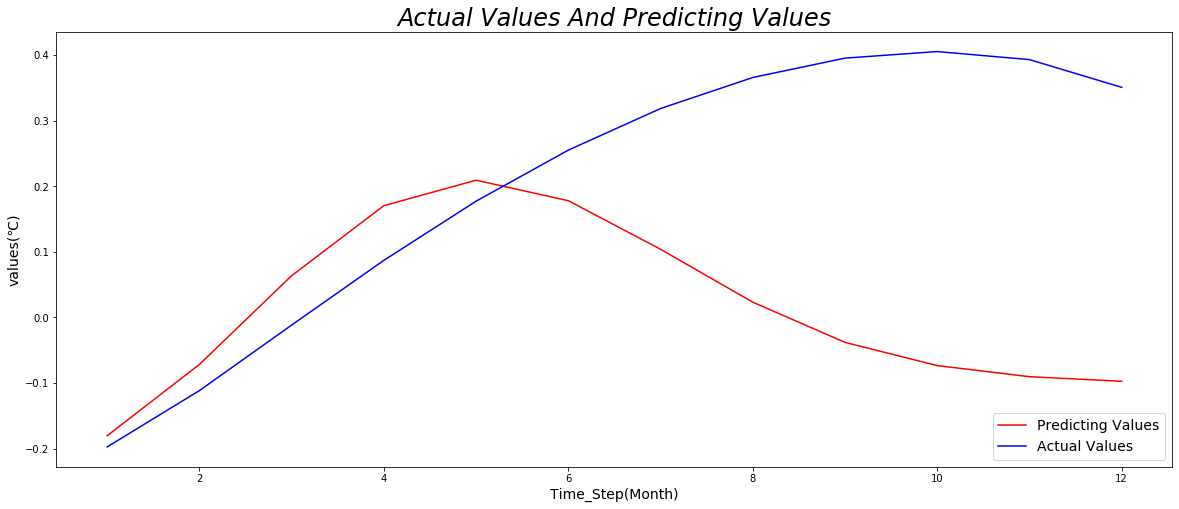

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
762    0.015288
763    0.017141
764    0.006707
765   -0.008962
766   -0.023666
767   -0.036315
768   -0.047196
769   -0.056760
770   -0.065907
771   -0.075071
772   -0.084464
773   -0.094279
774   -0.104070
775   -0.110790
776   -0.111170
777   -0.103810
778   -0.087494
779   -0.060201
780   -0.020648
781    0.028789
782    0.084824
783    0.144170
784    0.203540
785    0.259660
786    0.309220
787    0.348960
788    0.375580
789    0.385650
790    0.376110
791    0.347740
Name: f2, Length: 792, d

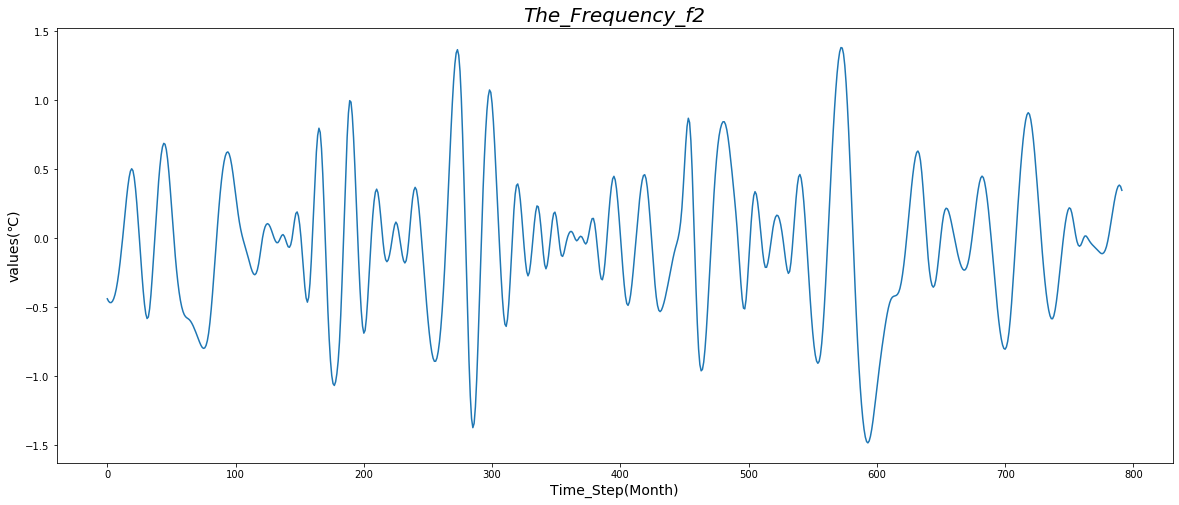

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 8s - loss: 0.2398
Epoch 2/200
 - 2s - loss: 0.2292
Epoch 3/200
 - 2s - loss: 0.2158
Epoch 4/200
 - 2s - loss: 0.1868
Epoch 5/200
 - 2s - loss: 0.1404
Epoch 6/200
 - 2s - loss: 0.1150
Epoch 7/200
 - 2s - loss: 0.0988
Epoch 8/200
 - 2s - loss: 0.0920
Epoch 9/200
 - 2s - loss: 0.0921
Epoch 10/200
 - 2s - loss: 0.0864
Epoch 11/200
 - 2s - loss: 0.0842
Epoch 12/200
 - 2s - loss: 0.0808
Epoch 13/200
 - 2s - loss: 0.0844
Epoch 14/200
 - 2s - loss: 0.0787
Epoch 15/200
 - 2s - loss: 0.0665
Epoch 16/200
 - 2s - loss: 0.0683
Epoch 17/200
 - 2s - loss: 0.0629
Epoch 18/200
 - 2s - loss: 0.0736
Epoch 19/200
 - 2s - loss: 0.0734
Epoch 20/200
 - 2s - loss: 0.0706
Epoch 21/200
 - 2s - loss: 0.0636
Epoch 22/200
 - 2s - loss: 0.0561
Epoch 23/200
 - 2s - loss: 0.0525
Epoch 24/200
 - 2s - loss: 0.0518
Epoch 25/200
 - 2s - loss: 0.0504
Epoch 26/200
 - 2s - loss: 0.0520
Epoch 27/200
 - 2s - loss: 0.0615
Epoch 28/200
 - 2s - loss: 0.0570
Epoch 29/200
 - 2s - loss: 0.0505
Epoch 30/200
 - 2s - lo

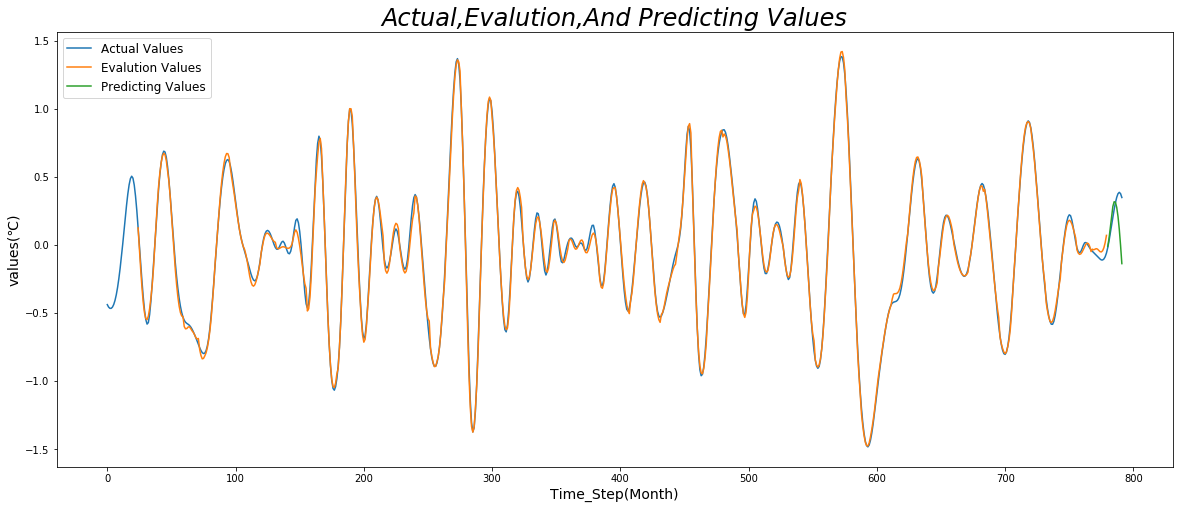

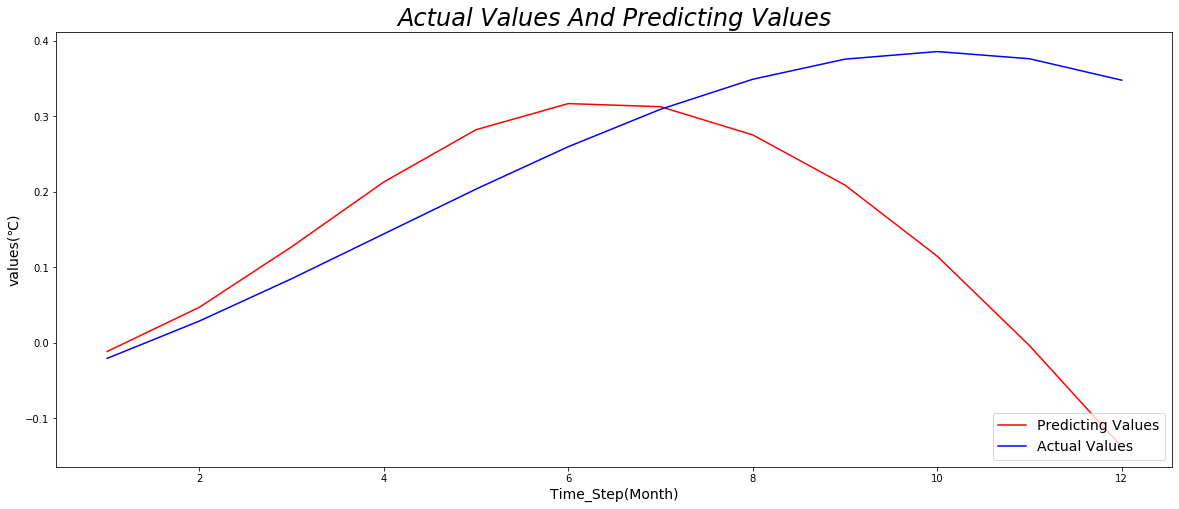

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
762   -0.295680
763   -0.331570
764   -0.355150
765   -0.366600
766   -0.366600
767   -0.356020
768   -0.335670
769   -0.306350
770   -0.268860
771   -0.224020
772   -0.172700
773   -0.115830
774   -0.054297
775    0.010972
776    0.079005
777    0.148710
778    0.218990
779    0.288710
780    0.356770
781    0.422070
782    0.483470
783    0.539890
784    0.590190
785    0.633270
786    0.668030
787    0.693340
788    0.708090
789    0.711310
790    0.702810
791    0.683290
Name: f3, Length: 792, d

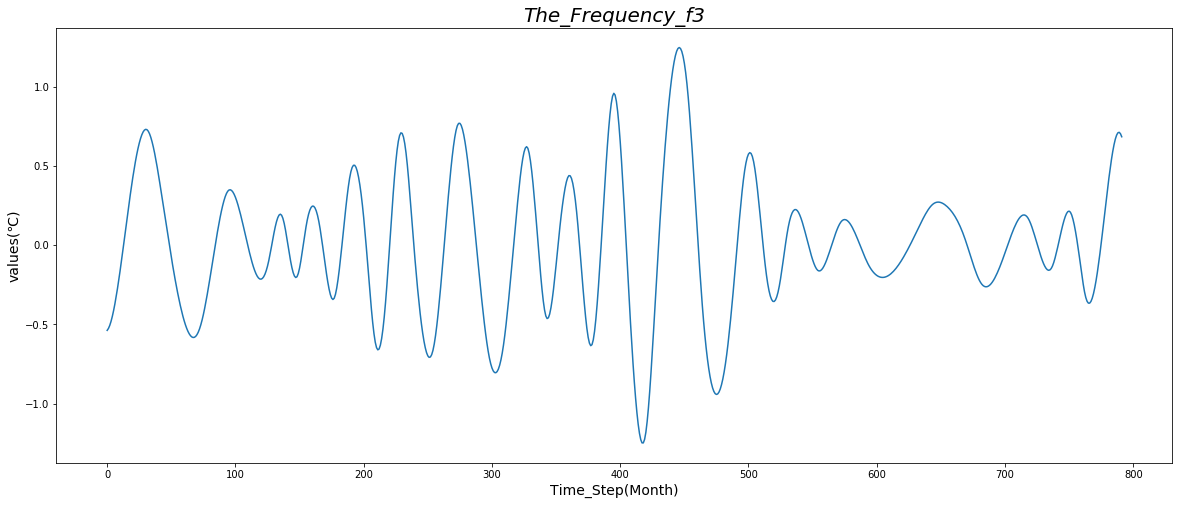

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 8s - loss: 0.1500
Epoch 2/200
 - 3s - loss: 0.1143
Epoch 3/200
 - 3s - loss: 0.0750
Epoch 4/200
 - 2s - loss: 0.0550
Epoch 5/200
 - 2s - loss: 0.0420
Epoch 6/200
 - 2s - loss: 0.0327
Epoch 7/200
 - 2s - loss: 0.0278
Epoch 8/200
 - 2s - loss: 0.0213
Epoch 9/200
 - 2s - loss: 0.0169
Epoch 10/200
 - 2s - loss: 0.0155
Epoch 11/200
 - 2s - loss: 0.0143
Epoch 12/200
 - 2s - loss: 0.0155
Epoch 13/200
 - 2s - loss: 0.0269
Epoch 14/200
 - 2s - loss: 0.0234
Epoch 15/200
 - 2s - loss: 0.0153
Epoch 16/200
 - 2s - loss: 0.0111
Epoch 17/200
 - 2s - loss: 0.0105
Epoch 18/200
 - 2s - loss: 0.0097
Epoch 19/200
 - 2s - loss: 0.0101
Epoch 20/200
 - 2s - loss: 0.0095
Epoch 21/200
 - 2s - loss: 0.0112
Epoch 22/200
 - 2s - loss: 0.0111
Epoch 23/200
 - 2s - loss: 0.0106
Epoch 24/200
 - 2s - loss: 0.0086
Epoch 25/200
 - 2s - loss: 0.0082
Epoch 26/200
 - 2s - loss: 0.0080
Epoch 27/200
 - 2s - loss: 0.0088
Epoch 28/200
 - 2s - loss: 0.0097
Epoch 29/200
 - 2s - loss: 0.0100
Epoch 30/200
 - 2s - lo

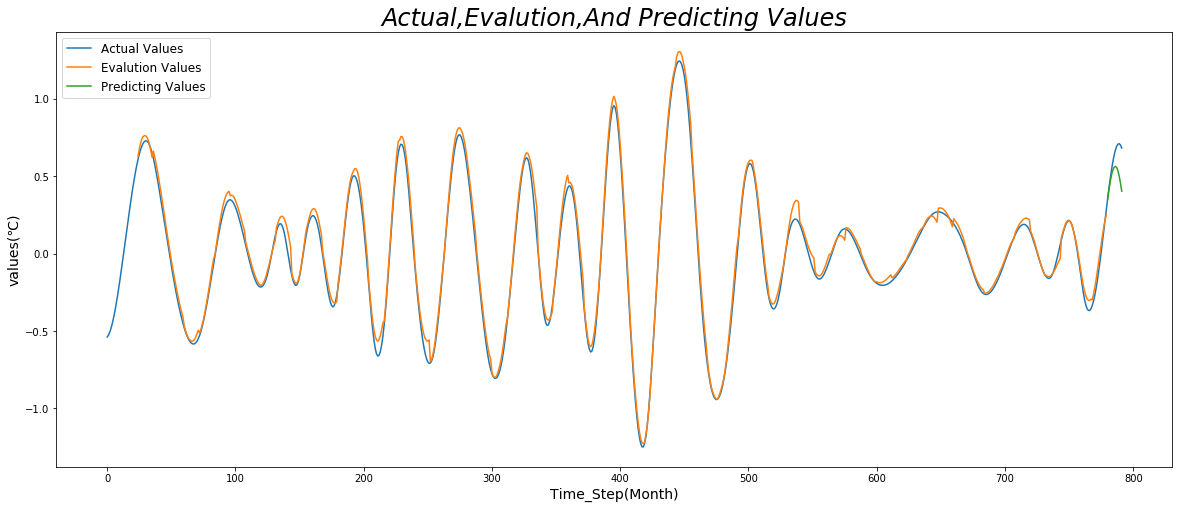

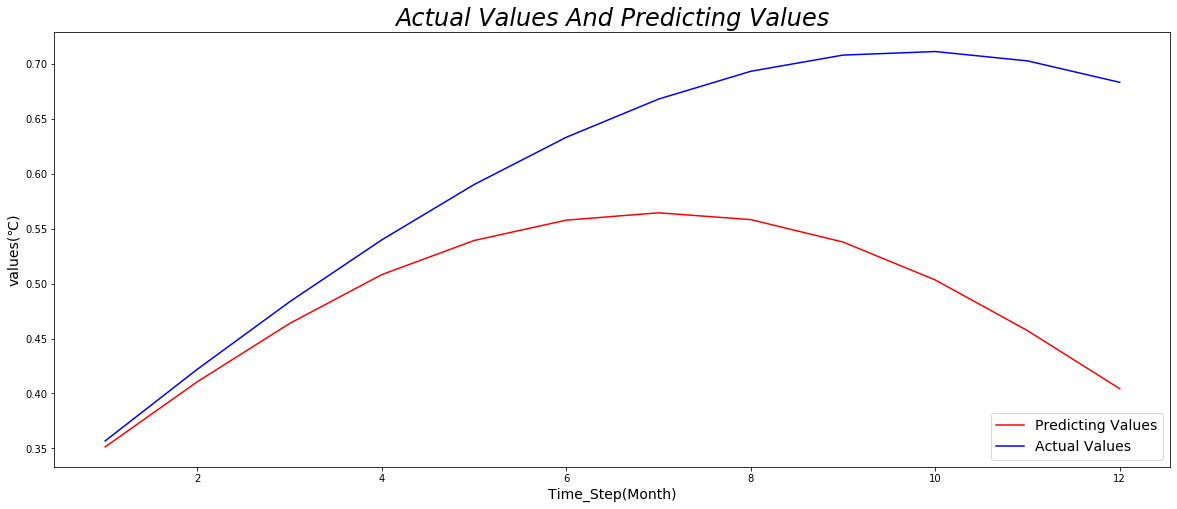

0     -0.215810
1     -0.214380
2     -0.212910
3     -0.211390
4     -0.209820
5     -0.208200
6     -0.206530
7     -0.204810
8     -0.203030
9     -0.201200
10    -0.199310
11    -0.197360
12    -0.195360
13    -0.193290
14    -0.191160
15    -0.188960
16    -0.186700
17    -0.184380
18    -0.181980
19    -0.179520
20    -0.176990
21    -0.174390
22    -0.171710
23    -0.168960
24    -0.166130
25    -0.163230
26    -0.160250
27    -0.157190
28    -0.154050
29    -0.150820
         ...   
762   -0.069505
763   -0.044291
764   -0.019166
765    0.005776
766    0.030458
767    0.054833
768    0.078862
769    0.102510
770    0.125730
771    0.148500
772    0.170770
773    0.192500
774    0.213650
775    0.234200
776    0.254090
777    0.273300
778    0.291780
779    0.309490
780    0.326400
781    0.342470
782    0.357660
783    0.371940
784    0.385250
785    0.397580
786    0.408870
787    0.419090
788    0.428200
789    0.436170
790    0.442980
791    0.448650
Name: f4, Length: 792, d

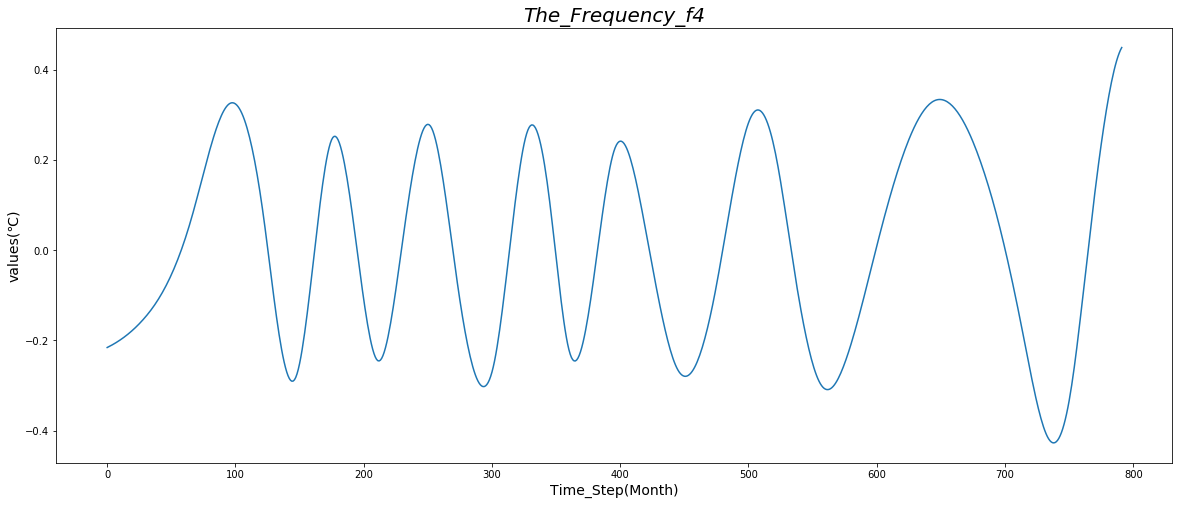

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 8s - loss: 0.0321
Epoch 2/200
 - 2s - loss: 0.0097
Epoch 3/200
 - 2s - loss: 0.0058
Epoch 4/200
 - 2s - loss: 0.0030
Epoch 5/200
 - 2s - loss: 0.0021
Epoch 6/200
 - 2s - loss: 0.0018
Epoch 7/200
 - 2s - loss: 0.0022
Epoch 8/200
 - 2s - loss: 0.0016
Epoch 9/200
 - 2s - loss: 8.7524e-04
Epoch 10/200
 - 2s - loss: 7.6646e-04
Epoch 11/200
 - 2s - loss: 0.0010
Epoch 12/200
 - 2s - loss: 6.7068e-04
Epoch 13/200
 - 2s - loss: 8.4500e-04
Epoch 14/200
 - 2s - loss: 9.2617e-04
Epoch 15/200
 - 2s - loss: 0.0012
Epoch 16/200
 - 2s - loss: 9.8638e-04
Epoch 17/200
 - 2s - loss: 8.4851e-04
Epoch 18/200
 - 2s - loss: 6.3776e-04
Epoch 19/200
 - 2s - loss: 6.1650e-04
Epoch 20/200
 - 2s - loss: 5.7918e-04
Epoch 21/200
 - 2s - loss: 0.0010
Epoch 22/200
 - 2s - loss: 7.8382e-04
Epoch 23/200
 - 2s - loss: 6.0451e-04
Epoch 24/200
 - 2s - loss: 6.9744e-04
Epoch 25/200
 - 2s - loss: 4.3179e-04
Epoch 26/200
 - 2s - loss: 5.5707e-04
Epoch 27/200
 - 2s - loss: 4.9406e-04
Epoch 28/200
 - 2s - loss: 

(63, 12)


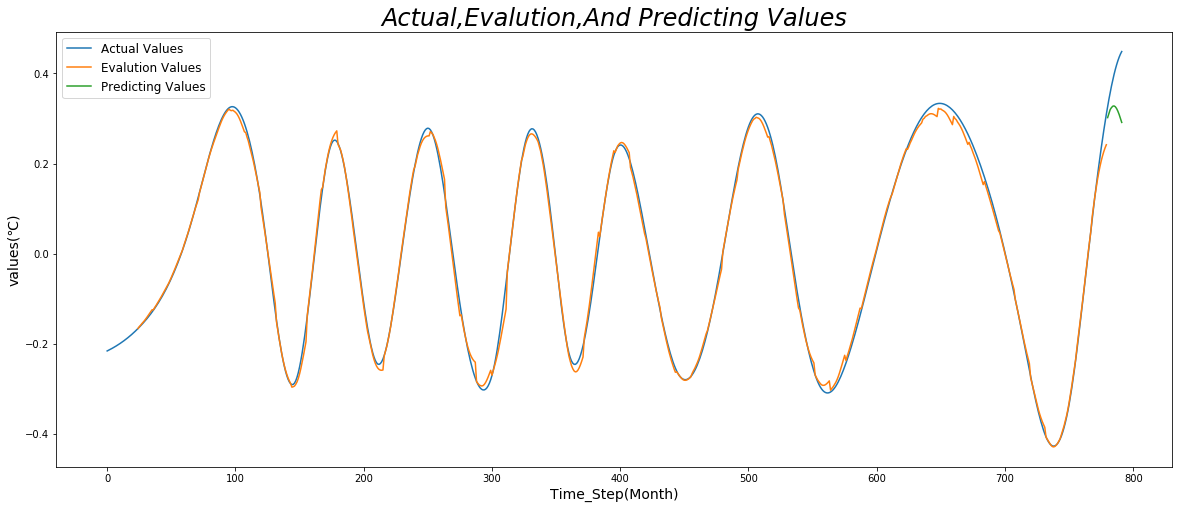

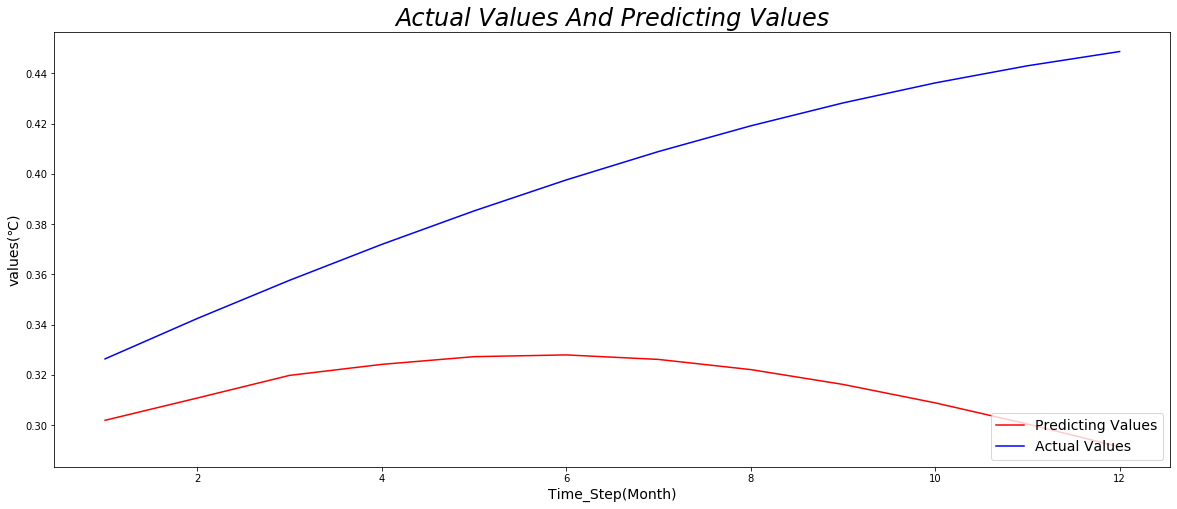

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
762    0.057028
763    0.060672
764    0.064282
765    0.067853
766    0.071384
767    0.074872
768    0.078314
769    0.081709
770    0.085052
771    0.088342
772    0.091576
773    0.094752
774    0.097867
775    0.100920
776    0.103900
777    0.106820
778    0.109660
779    0.112430
780    0.115130
781    0.117740
782    0.120270
783    0.122720
784    0.125080
785    0.127360
786    0.129540
787    0.131620
788    0.133610
789    0.135500
790    0.137280
791    0.138960
Name: f5, Length: 792, d

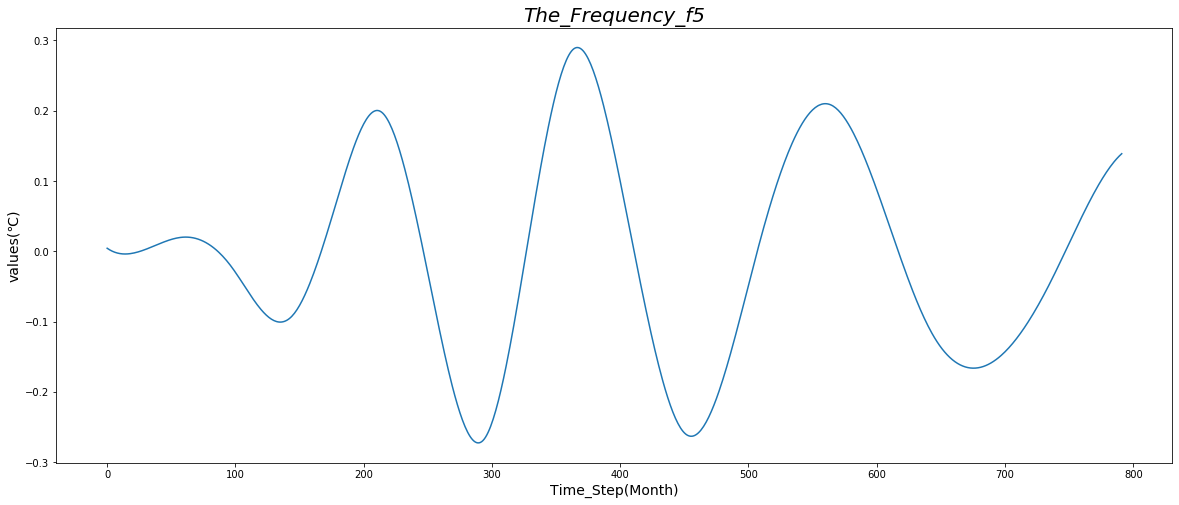

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 9s - loss: 0.0119
Epoch 2/200
 - 3s - loss: 0.0036
Epoch 3/200
 - 3s - loss: 8.4486e-04
Epoch 4/200
 - 4s - loss: 3.6662e-04
Epoch 5/200
 - 3s - loss: 2.1425e-04
Epoch 6/200
 - 2s - loss: 1.4590e-04
Epoch 7/200
 - 2s - loss: 1.5746e-04
Epoch 8/200
 - 2s - loss: 1.2098e-04
Epoch 9/200
 - 2s - loss: 9.9475e-05
Epoch 10/200
 - 2s - loss: 7.5370e-05
Epoch 11/200
 - 2s - loss: 6.8316e-05
Epoch 12/200
 - 2s - loss: 8.7414e-05
Epoch 13/200
 - 2s - loss: 8.3915e-05
Epoch 14/200
 - 2s - loss: 1.6687e-04
Epoch 15/200
 - 2s - loss: 1.2790e-04
Epoch 16/200
 - 2s - loss: 8.0040e-05
Epoch 17/200
 - 2s - loss: 4.4616e-05
Epoch 18/200
 - 2s - loss: 6.4536e-05
Epoch 19/200
 - 2s - loss: 5.0194e-05
Epoch 20/200
 - 2s - loss: 4.4171e-05
Epoch 21/200
 - 2s - loss: 1.0279e-04
Epoch 22/200
 - 2s - loss: 6.5978e-05
Epoch 23/200
 - 2s - loss: 5.8563e-05
Epoch 24/200
 - 2s - loss: 6.7026e-05
Epoch 25/200
 - 2s - loss: 3.9769e-05
Epoch 26/200
 - 2s - loss: 9.7394e-05
Epoch 27/200
 - 2s - loss: 1.

(63, 12)


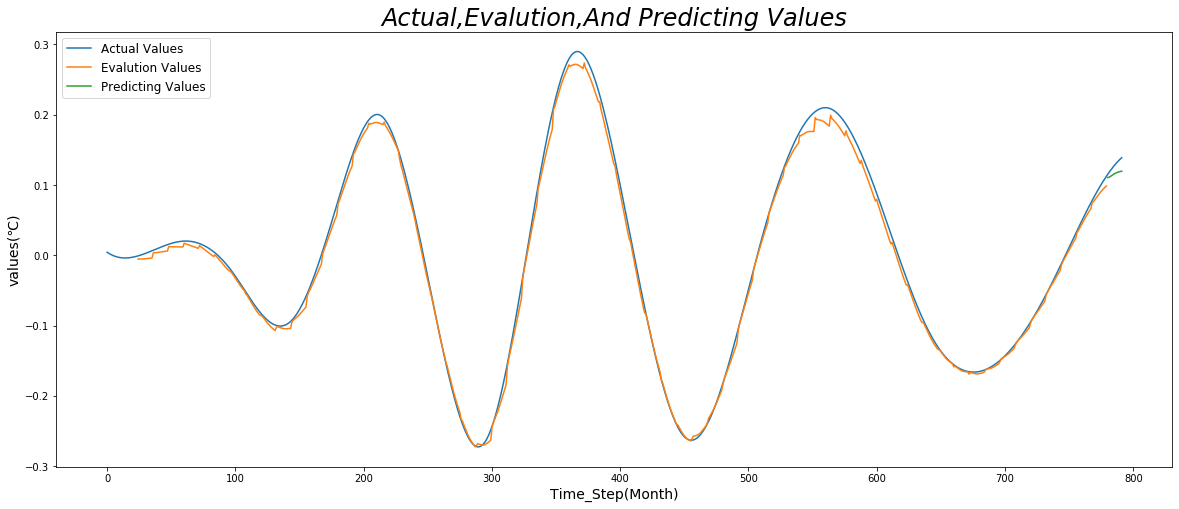

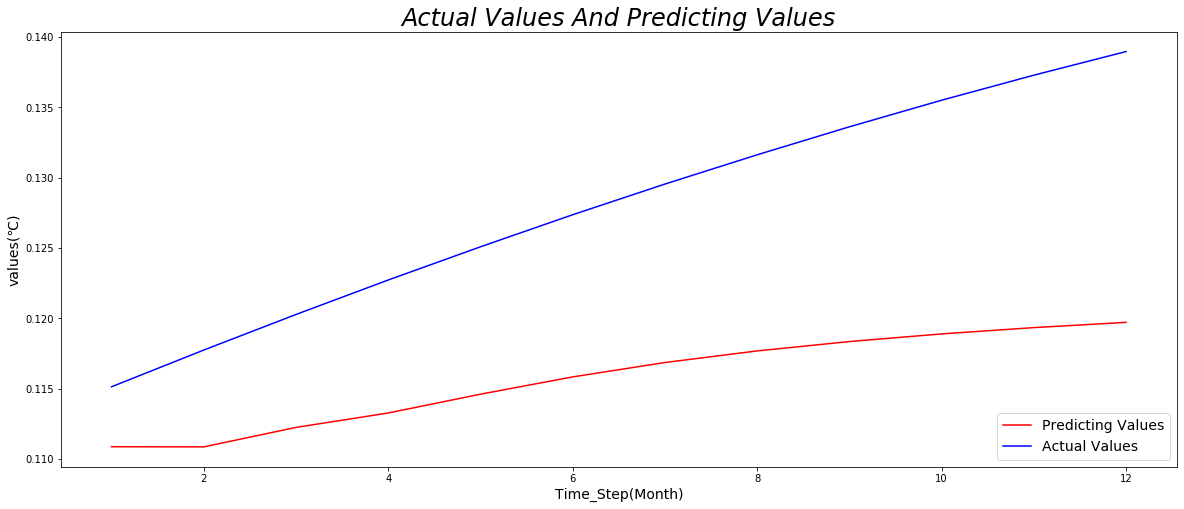

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
762   -0.14230
763   -0.14093
764   -0.13956
765   -0.13819
766   -0.13682
767   -0.13545
768   -0.13409
769   -0.13272
770   -0.13136
771   -0.13000
772   -0.12865
773   -0.12730
774   -0.12595
775   -0.12461
776   -0.12327
777   -0.12194
778   -0.12062
779   -0.11930
780   -0.11798
781   -0.11668
782   -0.11538
783   -0.11408
784   -0.11280
785   -0.11152
786   -0.11026
787   -0.10900
788   -0.10775
789   -0.10651
790   -0.10528
791   -0.10406
Name: f6, Length: 792, dtype: float64
(792,)


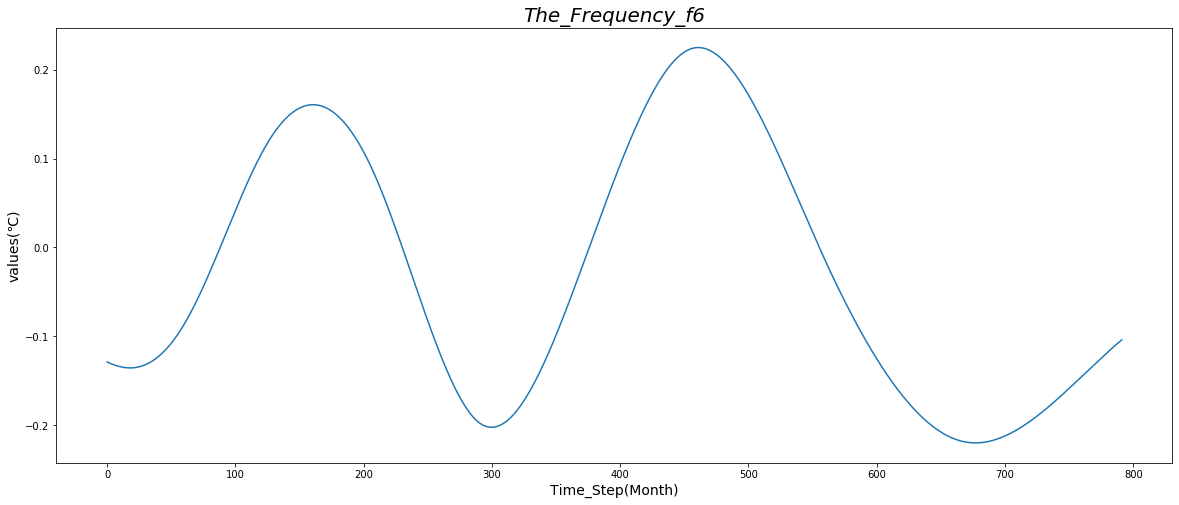

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 8s - loss: 0.0092
Epoch 2/200
 - 2s - loss: 0.0030
Epoch 3/200
 - 2s - loss: 0.0012
Epoch 4/200
 - 2s - loss: 3.4247e-04
Epoch 5/200
 - 2s - loss: 1.9414e-04
Epoch 6/200
 - 2s - loss: 9.6120e-05
Epoch 7/200
 - 2s - loss: 4.6536e-05
Epoch 8/200
 - 2s - loss: 1.9077e-05
Epoch 9/200
 - 2s - loss: 1.9025e-05
Epoch 10/200
 - 2s - loss: 2.0750e-05
Epoch 11/200
 - 2s - loss: 1.3393e-05
Epoch 12/200
 - 2s - loss: 1.4510e-05
Epoch 13/200
 - 2s - loss: 1.1752e-05
Epoch 14/200
 - 2s - loss: 1.1435e-05
Epoch 15/200
 - 2s - loss: 1.6085e-05
Epoch 16/200
 - 2s - loss: 2.0778e-05
Epoch 17/200
 - 2s - loss: 1.3788e-05
Epoch 18/200
 - 2s - loss: 4.2287e-05
Epoch 19/200
 - 2s - loss: 5.1132e-05
Epoch 20/200
 - 2s - loss: 2.9286e-05
Epoch 21/200
 - 2s - loss: 1.5499e-05
Epoch 22/200
 - 2s - loss: 2.7431e-05
Epoch 23/200
 - 2s - loss: 9.8642e-06
Epoch 24/200
 - 2s - loss: 1.3114e-05
Epoch 25/200
 - 2s - loss: 2.4418e-05
Epoch 26/200
 - 2s - loss: 9.9994e-06
Epoch 27/200
 - 2s - loss: 1.8193

(63, 12)


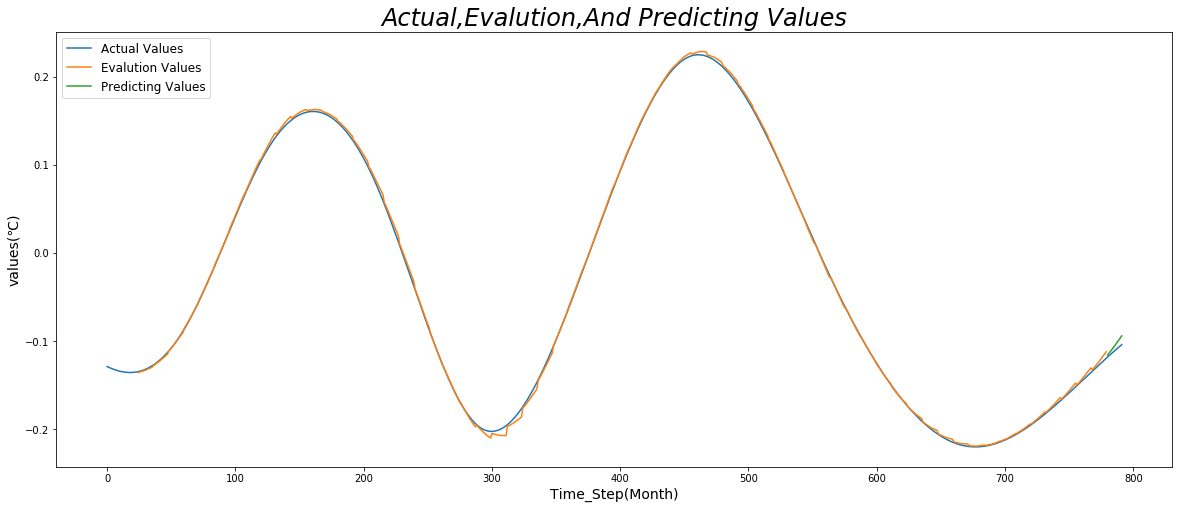

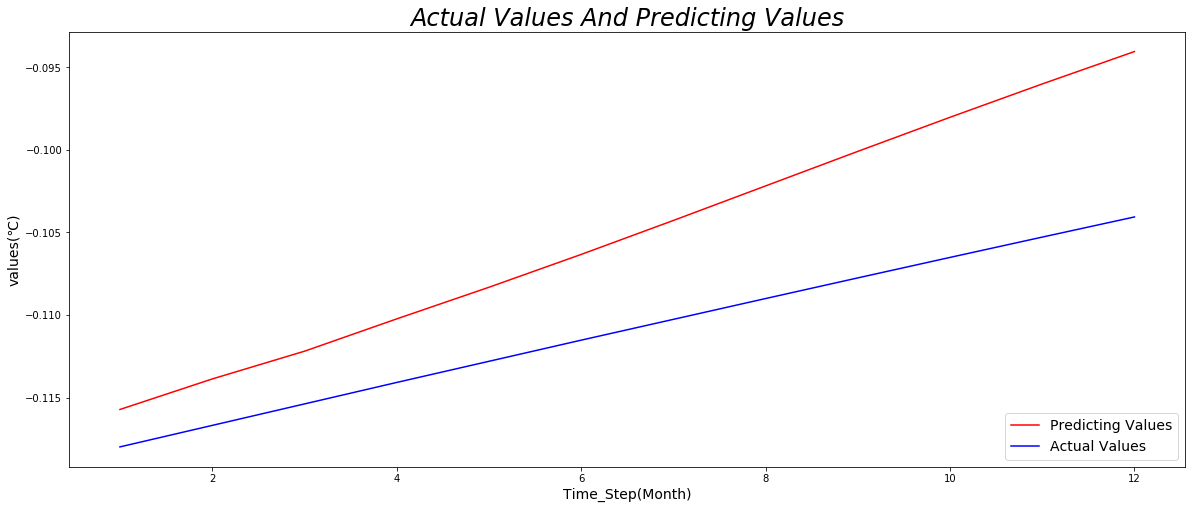

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
762    0.039523
763    0.039371
764    0.039216
765    0.039059
766    0.038901
767    0.038740
768    0.038577
769    0.038412
770    0.038245
771    0.038076
772    0.037905
773    0.037732
774    0.037557
775    0.037381
776    0.037202
777    0.037021
778    0.036838
779    0.036654
780    0.036467
781    0.036279
782    0.036089
783    0.035897
784    0.035703
785    0.035507
786    0.035310
787    0.035110
788    0.034909
789    0.034706
790    0.034502
791    0.034295
Name: f7, Length: 792, d

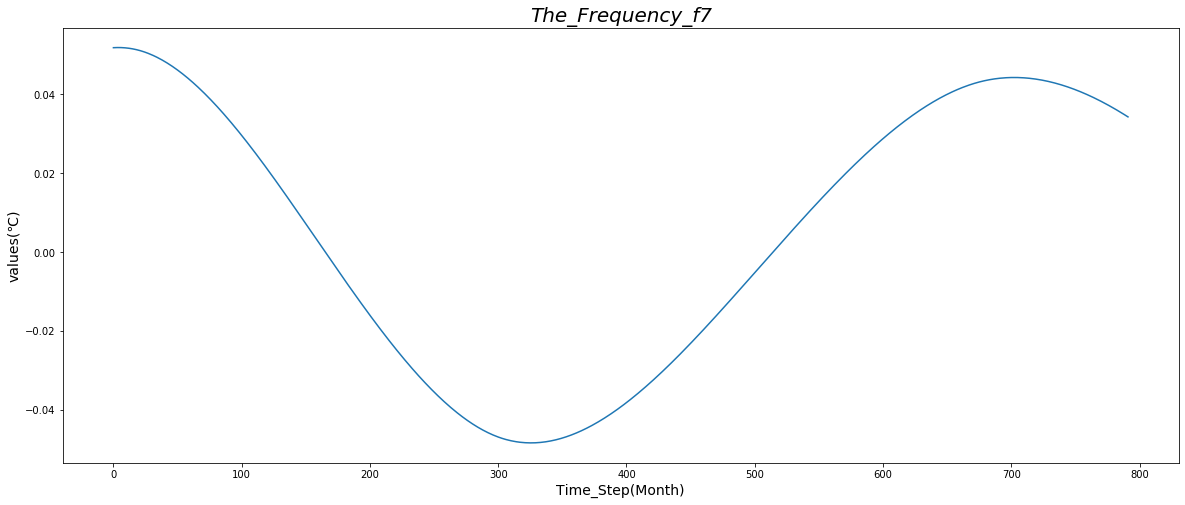

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 9s - loss: 8.3005e-04
Epoch 2/200
 - 2s - loss: 2.1994e-04
Epoch 3/200
 - 2s - loss: 1.3588e-04
Epoch 4/200
 - 2s - loss: 8.3344e-05
Epoch 5/200
 - 2s - loss: 5.5138e-05
Epoch 6/200
 - 2s - loss: 4.3748e-05
Epoch 7/200
 - 2s - loss: 4.1597e-05
Epoch 8/200
 - 2s - loss: 3.9390e-05
Epoch 9/200
 - 2s - loss: 2.7433e-05
Epoch 10/200
 - 2s - loss: 2.6977e-05
Epoch 11/200
 - 2s - loss: 2.6855e-05
Epoch 12/200
 - 2s - loss: 2.0674e-05
Epoch 13/200
 - 2s - loss: 2.1746e-05
Epoch 14/200
 - 2s - loss: 2.3239e-05
Epoch 15/200
 - 2s - loss: 1.5921e-05
Epoch 16/200
 - 2s - loss: 1.1042e-05
Epoch 17/200
 - 2s - loss: 2.1437e-05
Epoch 18/200
 - 2s - loss: 2.0301e-05
Epoch 19/200
 - 2s - loss: 1.2237e-05
Epoch 20/200
 - 2s - loss: 8.2296e-06
Epoch 21/200
 - 2s - loss: 5.0794e-06
Epoch 22/200
 - 2s - loss: 3.0399e-06
Epoch 23/200
 - 2s - loss: 7.9420e-07
Epoch 24/200
 - 2s - loss: 5.1833e-07
Epoch 25/200
 - 2s - loss: 5.2294e-07
Epoch 26/200
 - 2s - loss: 3.3565e-07
Epoch 27/200
 - 2s - 

(63, 12)


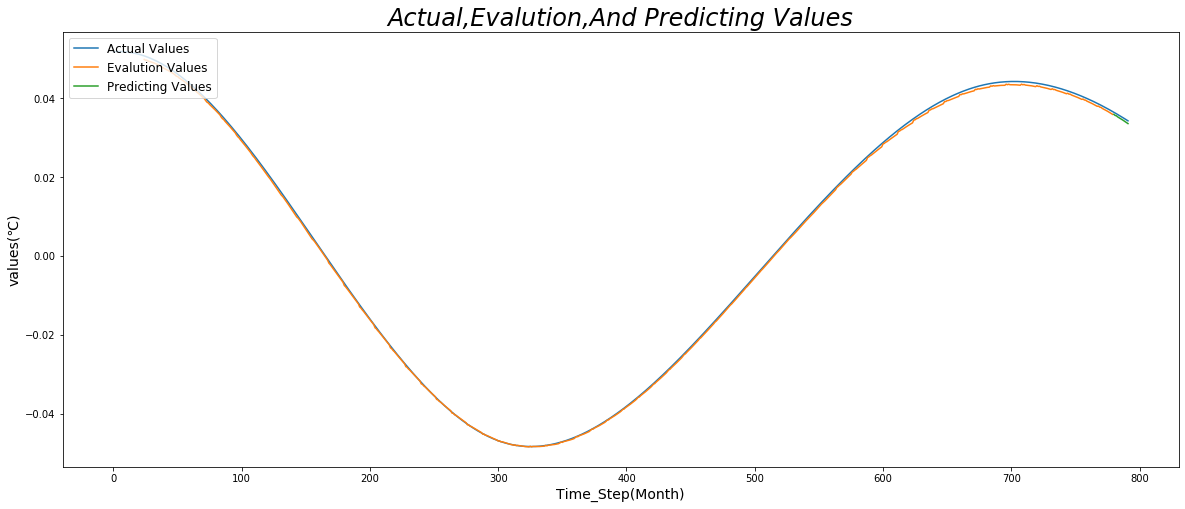

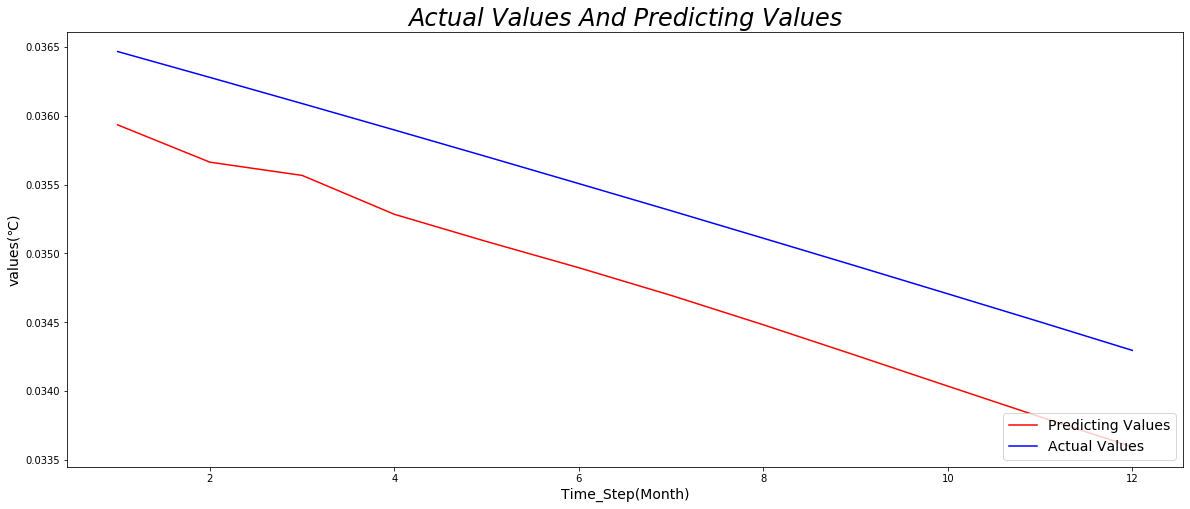

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
762    0.077796
763    0.077791
764    0.077786
765    0.077781
766    0.077776
767    0.077771
768    0.077766
769    0.077761
770    0.077756
771    0.077751
772    0.077746
773    0.077742
774    0.077737
775    0.077732
776    0.077728
777    0.077723
778    0.077718
779    0.077714
780    0.077709
781    0.077705
782    0.077701
783    0.077696
784    0.077692
785    0.077688
786    0.077683
787    0.077679
788    0.077675
789    0.077671
790    0.077667
791    0.077663
Name: f8, Length: 792, d

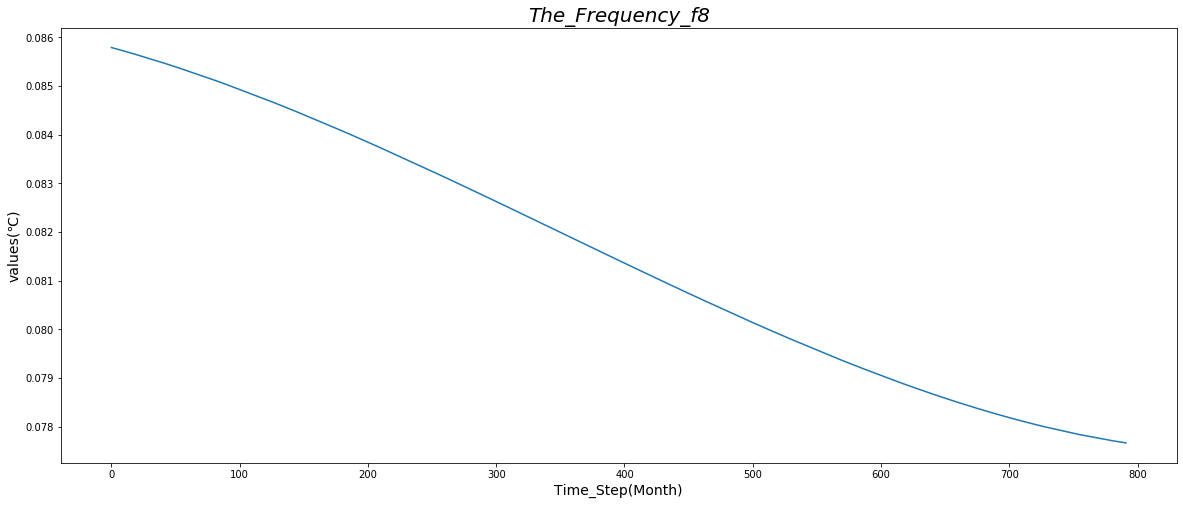

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 9s - loss: 5.5732e-04
Epoch 2/200
 - 3s - loss: 1.3967e-05
Epoch 3/200
 - 2s - loss: 7.5409e-06
Epoch 4/200
 - 3s - loss: 6.7556e-06
Epoch 5/200
 - 2s - loss: 6.7270e-06
Epoch 6/200
 - 2s - loss: 6.3880e-06
Epoch 7/200
 - 2s - loss: 6.4402e-06
Epoch 8/200
 - 2s - loss: 6.2060e-06
Epoch 9/200
 - 2s - loss: 6.4060e-06
Epoch 10/200
 - 2s - loss: 6.2964e-06
Epoch 11/200
 - 2s - loss: 6.3639e-06
Epoch 12/200
 - 2s - loss: 6.4924e-06
Epoch 13/200
 - 2s - loss: 6.9314e-06
Epoch 14/200
 - 2s - loss: 6.3543e-06
Epoch 15/200
 - 2s - loss: 6.3950e-06
Epoch 16/200
 - 2s - loss: 6.9534e-06
Epoch 17/200
 - 2s - loss: 6.3514e-06
Epoch 18/200
 - 2s - loss: 6.0486e-06
Epoch 19/200
 - 2s - loss: 6.6030e-06
Epoch 20/200
 - 2s - loss: 6.3486e-06
Epoch 21/200
 - 2s - loss: 6.9471e-06
Epoch 22/200
 - 2s - loss: 6.8442e-06
Epoch 23/200
 - 2s - loss: 6.0751e-06
Epoch 24/200
 - 2s - loss: 6.8989e-06
Epoch 25/200
 - 2s - loss: 6.5700e-06
Epoch 26/200
 - 2s - loss: 6.3064e-06
Epoch 27/200
 - 2s - 

(63, 12)


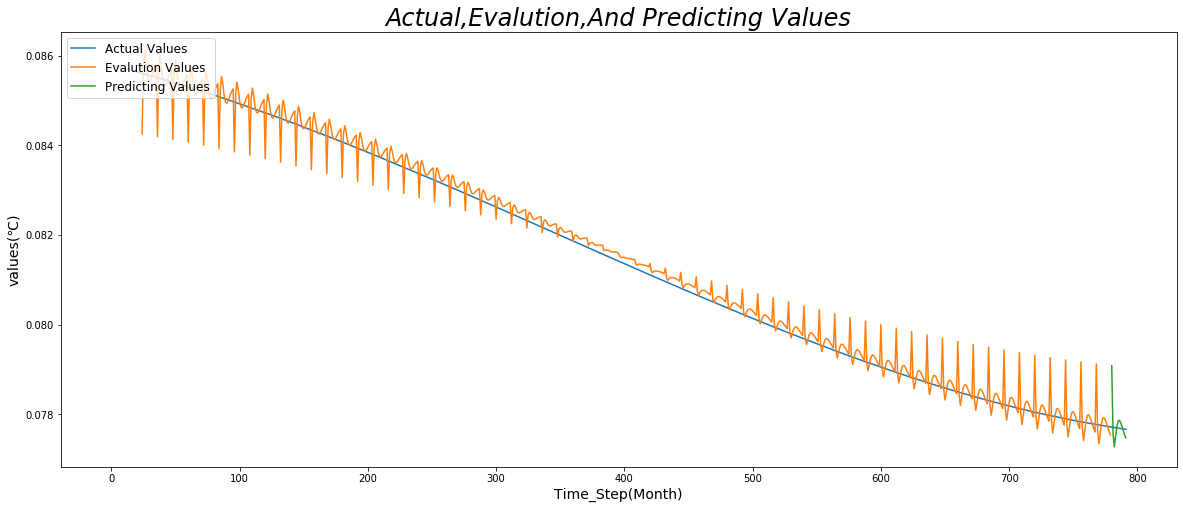

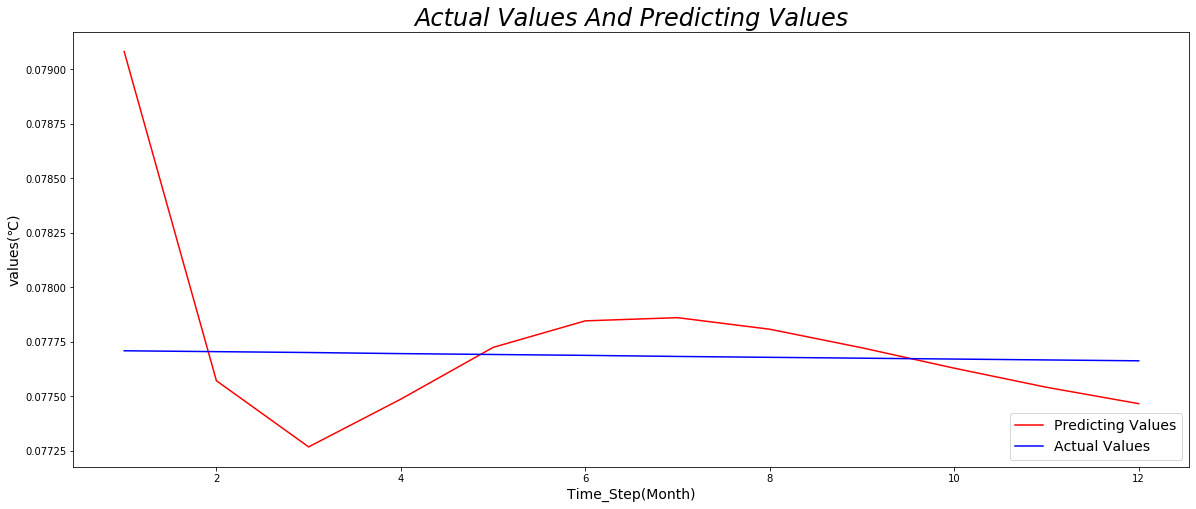

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-36]
    print (dataset)
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07908109]
 [0.0775717 ]
 [0.07726827]
 [0.07748732]
 [0.0777245 ]
 [0.07784623]
 [0.07786082]
 [0.07780778]
 [0.07772253]
 [0.07762921]
 [0.07754166]
 [0.0774665 ]]
[array([ 0.023459, -0.19688 , -0.43302 , -0.46527 , -0.48188 , -0.47457 ,
       -0.33684 , -0.16255 ,  0.05442 ,  0.32021 ,  0.44094 ,  0.62276 ]), array([-0.19731 , -0.1115  , -0.011624,  0.087047,  0.17722 ,  0.25504 ,
        0.31845 ,  0.36576 ,  0.39527 ,  0.4053  ,  0.39299 ,  0.35071 ]), array([-0.020648,  0.028789,  0.084824,  0.14417 ,  0.20354 ,  0.25966 ,
        0.30922 ,  0.34896 ,  0.37558 ,  0.38565 ,  0.37611 ,  0.34774 ]), array([0.35677, 0.42207, 0.48347, 0.53989, 0.59019, 0.63327, 0.66803,
       0.69334, 0.70809, 0.71131, 0.70281, 0.68329]), array([0.3264 , 0.34247, 0.35766, 0.37194, 0.38525, 0.39758, 0.40887,
       0.41909, 0.4282 , 0.43617, 0.44298, 0.44865]), array([0.11513, 0.11774, 0.12027, 0.12272, 0.12508, 0.12736, 0.12954,
       0.13162, 0.13361, 0.1355 , 0.13728, 0.13896]), array([-0.1179

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[ 0.023459 -0.19688  -0.43302  -0.46527  -0.48188  -0.47457  -0.33684
 -0.16255   0.05442   0.32021   0.44094   0.62276 ]
[[ 0.023459]
 [-0.19688 ]
 [-0.43302 ]
 [-0.46527 ]
 [-0.48188 ]
 [-0.47457 ]
 [-0.33684 ]
 [-0.16255 ]
 [ 0.05442 ]
 [ 0.32021 ]
 [ 0.44094 ]
 [ 0.62276 ]]
[[ 0.02]
 [-0.2 ]
 [-0.43]
 [-0.47]
 [-0.48]
 [-0.47]
 [-0.34]
 [-0.16]
 [ 0.05]
 [ 0.32]
 [ 0.44]
 [ 0.62]]
-----------------------------------
observe value:[-0.19731  -0.1115   -0.011624  0.087047  0.17722   0.25504   0.31845
  0.36576   0.39527   0.4053    0.39299   0.35071 ]
[[-0.173851]
 [-0.30838 ]
 [-0.444644]
 [-0.378223]
 [-0.30466 ]
 [-0.21953 ]
 [-0.01839 ]
 [ 0.20321 ]
 [ 0.44969 ]
 [ 0.72551 ]
 [ 0.83393 ]
 [ 0.97347 ]]
[[-0.17]
 [-0.31]
 [-0.44]
 [-0.38]
 [-0.3 ]
 [-0.22]
 [-0.02]
 [ 0.2 ]
 [ 0.45]
 [ 0.73]
 [ 0.83]
 [ 0.97]]
-----------------------------------
observe value:[-0.020648  0.028789  0.084824  0.14417   0.20354   0.25966   0.30922
  0.34896   0.37558   0.38565   0.37611 

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.07557898 -0.20844787 -0.343343   -0.24156012  0.00406309  0.13165657
 -0.00079512 -0.23527862 -0.16832672  0.15909663  0.31136468  0.2514095 ]
[ 0.07557898 -0.20844787 -0.34334299 -0.24156012  0.00406309  0.13165657
 -0.00079512 -0.23527862 -0.16832672  0.15909663  0.31136468  0.2514095 ]
the 1 frequence:
predicted_value:[-0.18033616 -0.07161131  0.06365961  0.17038064  0.20918481  0.17794397
  0.10392585  0.02327445 -0.03800904 -0.07338725 -0.09029325 -0.09731784]
[-0.10475718 -0.28005918 -0.27968338 -0.07117948  0.2132479   0.30960055
  0.10313073 -0.21200418 -0.20633576  0.08570938  0.22107143  0.15409166]
the 2 frequence:
predicted_value:[-0.01154789  0.04702323  0.1271017   0.21296532  0.2821643   0.31672043
  0.31262484  0.2752295   0.20880742  0.11466113 -0.00371288 -0.13786745]
[-0.11630507 -0.23303595 -0.15258168  0.14178585  0.4954122   0.62632097
  0.41575557  0.06322534  0.00247166  0.20037051  0.217

[[0.6]
 [0.6]
 [0.6]
 [0.8]
 [1. ]
 [1.2]
 [1.5]
 [1.8]
 [2.1]
 [2.4]
 [2.5]
 [2.6]]
[0.6471787  0.59871853 0.74386575 1.09002976 1.48106207 1.63434431
 1.43155453 1.07142175 0.98681175 1.14512161 1.10975078 0.84867126]


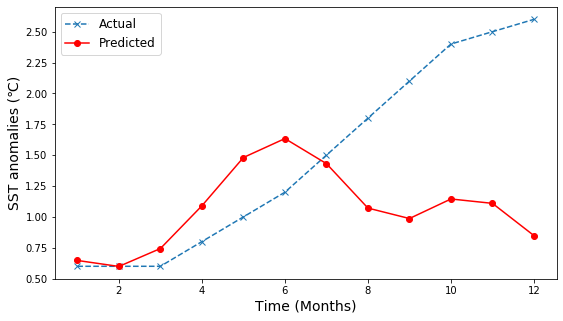

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 
